In [9]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import RandomSearch

# Load the simulation data from the file
data = np.load('simulation_data.npz')
training_data = data['training_data']
testing_data = data['testing_data']

print(training_data.shape)

# Define dimensions based on your data
num_samples = training_data.shape[0]
num_snapshots = training_data.shape[1]
num_points = training_data.shape[2]
num_channels = training_data.shape[3]

(100, 3, 50, 100)


In [8]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import RandomSearch

# Load the simulation data from the file
data = np.load('simulation_data.npz')
training_data = data['training_data']
testing_data = data['testing_data']

# Define dimensions based on your data
num_samples = training_data.shape[0]
num_snapshots = training_data.shape[1]
num_points = training_data.shape[2]
num_channels = training_data.shape[3]

# Prediction parameters
predicted_snapshots = 10

# Ensuring num_snapshots is properly used
if num_snapshots <= predicted_snapshots:
    raise ValueError(f"num_snapshots ({num_snapshots}) must be greater than predicted_snapshots ({predicted_snapshots})")

# Reshape and prepare the data
X_train = training_data[:, :num_snapshots - predicted_snapshots, :, :]
Y_train = training_data[:, -predicted_snapshots:, :, :]
X_test = testing_data[:, :num_snapshots - predicted_snapshots, :, :]
Y_test = testing_data[:, -predicted_snapshots:, :, :]

# Ensure the channels are last
X_train = np.transpose(X_train, (0, 1, 2, 3))
X_test = np.transpose(X_test, (0, 1, 2, 3))
Y_train = np.transpose(Y_train, (0, 1, 2, 3))
Y_test = np.transpose(Y_test, (0, 1, 2, 3))

# Print shapes for sanity
print("Shape of X_train:", X_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of Y_test:", Y_test.shape)

# Define the model with hyperparameters using Keras Tuner
def build_model(hp):
    model = keras.Sequential([
        layers.Conv2D(
            filters=hp.Int('filters', min_value=32, max_value=128, step=32),
            kernel_size=(3, 3), activation='relu',
            input_shape=(num_snapshots - predicted_snapshots, num_points, num_channels),
            padding='same'),
        layers.BatchNormalization(),
        layers.Flatten(),
        # Calculate the correct number of units for LSTM input
        layers.Reshape((num_snapshots - predicted_snapshots, num_points * num_channels)),
        layers.LSTM(hp.Int('lstm_units', min_value=32, max_value=128, step=32), return_sequences=True),
        layers.LSTM(hp.Int('lstm_units_2', min_value=32, max_value=128, step=32)),
        layers.Dense(predicted_snapshots * num_points * num_channels),
        # Ensure the output reshape matches the expected output shape
        layers.Reshape((predicted_snapshots, num_points, num_channels))
    ])
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])), loss='mse')
    return model

# Hyperparameter tuning
tuner = RandomSearch(build_model, objective='val_loss', max_trials=10, executions_per_trial=1,
    directory='store_best_model',
    project_name='spatio_temporal_model_3D')

# Early stopping to prevent overfitting
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Perform hyperparameter search
tuner.search(
    X_train, Y_train,
    epochs=20,
    validation_split=0.2,
    callbacks=[early_stopping_callback],
    verbose=1
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate on test data
test_loss = best_model.evaluate(X_test, Y_test, verbose=1)
print(f"Test Loss: {test_loss}")

# Visualization of results
def visualize_comparisons(X_test, Y_test, Y_test_pred, indices, channel_names=["Density", "Velocity", "Temperature"]):
    num_channels = len(channel_names)
    num_samples = len(indices)
    fig, axes = plt.subplots(num_samples, num_channels*2, figsize=(20, num_samples*3))
    
    for idx, sample_index in enumerate(indices):
        for channel_index in range(num_channels):
            # Actual
            ax = axes[idx, channel_index*2]
            actual = X_test[sample_index, :, :, channel_index]
            im = ax.imshow(actual, aspect='auto')
            ax.set_title(f'Actual {channel_names[channel_index]}')
            plt.colorbar(im, ax=ax)
            
            # Prediction
            ax = axes[idx, channel_index*2 + 1]
            prediction = Y_test_pred[sample_index, :, :, channel_index]
            im = ax.imshow(prediction, aspect='auto')
            ax.set_title(f'Predicted {channel_names[channel_index]}')
            plt.colorbar(im, ax=ax)
    
    plt.tight_layout()
    plt.show()

# Select some indices to visualize
indices_to_visualize = [0, 10, 32]

# Assuming Y_test_pred has been reshaped correctly as per previous steps
visualize_comparisons(X_test, Y_test, Y_test_pred, indices_to_visualize)


ValueError: num_snapshots (3) must be greater than predicted_snapshots (10)

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import RandomSearch

# Load the simulation data from the file
data = np.load('simulation_data.npz')
training_data = data['training_data']
testing_data = data['testing_data']

# Define dimensions based on your data
num_samples = training_data.shape[0]
num_channels = training_data.shape[1]
num_snapshots = training_data.shape[2]
num_points = training_data.shape[3]

# Prediction parameters
predicted_snapshots = 10  # How many future snapshots to predict

# Preparing the data for training and testing
# Extracting features and labels from the training data
X_train = training_data[:, :, :num_snapshots - predicted_snapshots, :]
Y_train = training_data[:, :, -predicted_snapshots:, :]
X_test = testing_data[:, :, :num_snapshots - predicted_snapshots, :]
Y_test = testing_data[:, :, -predicted_snapshots:, :]

# Print shapes for sanity
print("Shape of X_train:", X_train.shape)
print("Shape of Y_train:", Y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of Y_test:", Y_test.shape)

# Define the model with hyperparameters using Keras Tuner
def build_model(hp):
    model = keras.Sequential([
        layers.Conv3D(
            filters=hp.Int('filters', min_value=32, max_value=128, step=32),
            kernel_size=(3, 3, 3), activation='relu',
            input_shape=(num_channels, num_snapshots - predicted_snapshots, num_points, 1),
            padding='same'),
        layers.BatchNormalization(),
        layers.Flatten(),
        layers.Dense(hp.Int('dense_units', min_value=64, max_value=512, step=64), activation='relu'),
        layers.Reshape((num_channels, predicted_snapshots, num_points, 1)),  # Reshape output to match Y_train
        layers.Conv3D(filters=1, kernel_size=(1, 1, 1), activation='linear')
    ])
    model.compile(optimizer=keras.optimizers.Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])), loss='mse')
    return model

# Hyperparameter tuning setup
tuner = RandomSearch(build_model, objective='val_loss', max_trials=10, executions_per_trial=1,
    directory='store_best_model', project_name='spatio_temporal_model_3D')

# Early stopping to prevent overfitting
early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Perform hyperparameter search
tuner.search(
    X_train, Y_train,
    epochs=20,
    validation_split=0.2,
    callbacks=[early_stopping_callback],
    verbose=1
)

# Get the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate on test data
test_loss = best_model.evaluate(X_test, Y_test, verbose=1)
print(f"Test Loss: {test_loss}")

# Visualization and further analysis here...

Shape of X_train: (100, 3, 40, 100)
Shape of Y_train: (100, 3, 10, 100)
Shape of X_test: (100, 3, 40, 100)
Shape of Y_test: (100, 3, 10, 100)
Reloading Tuner from store_best_model\spatio_temporal_model_3D\tuner0.json


ValueError: Exception encountered when calling layer "reshape" (type Reshape).

total size of new array must be unchanged, input_shape = [64], output_shape = [3, 10, 100, 1]

Call arguments received by layer "reshape" (type Reshape):
  • inputs=tf.Tensor(shape=(None, 64), dtype=float32)

Model: "model_6"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 3, 50, 100)  0           []                               
                                ]                                                                 
                                                                                                  
 lambda_18 (Lambda)             (None, 50, 100)      0           ['input_7[0][0]']                
                                                                                                  
 lambda_19 (Lambda)             (None, 50, 100)      0           ['input_7[0][0]']                
                                                                                                  
 lambda_20 (Lambda)             (None, 50, 100)      0           ['input_7[0][0]']          

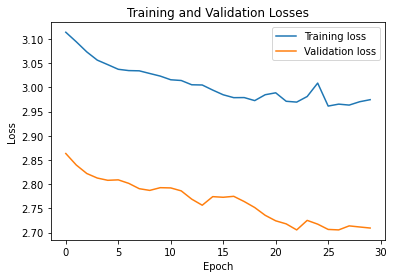

In [23]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load the simulation data from the file
data = np.load('simulation_data.npz')
training_data = data['training_data']
testing_data = data['testing_data']

# Define dimensions based on your data
num_samples = training_data.shape[0]
num_channels = training_data.shape[1]
num_snapshots = training_data.shape[2]
num_points = training_data.shape[3]
predicted_snapshots = 10  # define how many future snapshots you want to predict

def create_model():
    # Input shape: (num_channels, num_snapshots, num_points)
    input_layer = keras.Input(shape=(num_channels, num_snapshots, num_points))

    # Process each channel with its own CNN
    processed_channels = []
    for i in range(num_channels):
        # Slice the input to get each channel's data separately
        channel_input = layers.Lambda(lambda x: x[:, i])(input_layer)
        channel_input = layers.Reshape((num_snapshots, num_points, 1))(channel_input)  # Add channel dimension for CNN

        # CNN layers to extract spatial features from each snapshot
        cnn = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(channel_input)
        cnn = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(cnn)
        cnn = layers.BatchNormalization()(cnn)
        cnn = layers.MaxPooling2D((2, 2))(cnn)
        cnn = layers.Flatten()(cnn)

        # Prepare CNN output for LSTM input
        cnn = layers.Reshape((num_snapshots, -1))(cnn)
        processed_channels.append(cnn)

    # Concatenate processed channels
    concatenated = layers.Concatenate(axis=-1)(processed_channels)

    # LSTM layers to analyze temporal data
    lstm = layers.LSTM(128, return_sequences=True)(concatenated)
    lstm = layers.LSTM(64, return_sequences=False)(lstm)

    # Dense layer to predict future snapshots
    dense = layers.Dense(predicted_snapshots * num_points * num_channels, activation='relu')(lstm)
    output_layer = layers.Reshape((num_channels, predicted_snapshots, num_points))(dense)

    model = keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mse')

    return model

# Instantiate and compile the model
model = create_model()
model.summary()

# Train the model
history = model.fit(
    training_data,  # Ensure training_data is appropriately reshaped if needed
    training_data[:, :, -predicted_snapshots:, :],  # Use the last 'predicted_snapshots' from training_data as labels
    epochs=30,
    batch_size=32,
    validation_split=0.2
)

# Evaluate the model on the test data
test_loss = model.evaluate(
    testing_data,  # Ensure testing_data is appropriately reshaped if needed
    testing_data[:, :, -predicted_snapshots:, :]  # Use the last 'predicted_snapshots' from testing_data as labels
)
print('Test Loss:', test_loss)

# Optionally, visualize training history
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/30
3/3 [==============================] - 4s 1s/step - loss: 1.1262 - val_loss: 0.9198 - lr: 0.0010
Epoch 2/30
3/3 [==============================] - 4s 1s/step - loss: 1.0599 - val_loss: 0.9184 - lr: 0.0010
Epoch 3/30
3/3 [==============================] - 4s 1s/step - loss: 1.0382 - val_loss: 0.8833 - lr: 0.0010
Epoch 4/30
3/3 [==============================] - 3s 1s/step - loss: 1.0379 - val_loss: 0.8775 - lr: 0.0010
Epoch 5/30
3/3 [==============================] - 4s 1s/step - loss: 1.0283 - val_loss: 0.8778 - lr: 0.0010
Epoch 6/30
3/3 [==============================] - 4s 1s/step - loss: 1.0228 - val_loss: 0.8753 - lr: 0.0010
Epoch 7/30
3/3 [==============================] - 3s 1s/step - loss: 1.0221 - val_loss: 0.8751 - lr: 0.0010
Epoch 8/30
3/3 [==============================] - 3s 1s/step - loss: 1.0181 - val_loss: 0.8750 - lr: 0.0010
Epoch 9/30
3/3 [==============================] - 3s 1s/step - loss: 1.0171 - val_loss: 0.8780 - lr: 0.0010
Epoch 10/30
3/3 [===========

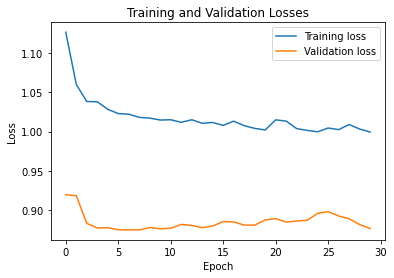

In [24]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Function to decay the learning rate
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.01)

lr_callback = LearningRateScheduler(scheduler)

# Normalize your data (if not already normalized)
# Ensure that the normalization is done per feature across all snapshots
mean = training_data.mean(axis=(0, 2), keepdims=True)
std = training_data.std(axis=(0, 2), keepdims=True)
training_data_normalized = (training_data - mean) / std
testing_data_normalized = (testing_data - mean) / std

# Train the model
history = model.fit(
    training_data_normalized,
    training_data_normalized[:, :, -predicted_snapshots:, :],  # Labels are normalized too
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[lr_callback]  # Add the learning rate scheduler callback
)

# Evaluate on test data (also normalized)
test_loss = model.evaluate(
    testing_data_normalized,
    testing_data_normalized[:, :, -predicted_snapshots:, :]  # Labels are normalized too
)
print('Test Loss:', test_loss)

# Plot training history
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 3, 50, 100)  0           []                               
                                ]                                                                 
                                                                                                  
 lambda_21 (Lambda)             (None, 50, 100)      0           ['input_8[0][0]']                
                                                                                                  
 lambda_22 (Lambda)             (None, 50, 100)      0           ['input_8[0][0]']                
                                                                                                  
 lambda_23 (Lambda)             (None, 50, 100)      0           ['input_8[0][0]']          

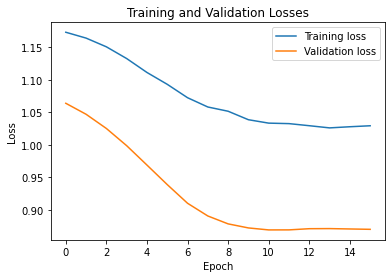

In [25]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import matplotlib.pyplot as plt

# Load the simulation data from the file
data = np.load('simulation_data.npz')
training_data = data['training_data']
testing_data = data['testing_data']

# Define dimensions based on your data
num_samples = training_data.shape[0]
num_channels = training_data.shape[1]
num_snapshots = training_data.shape[2]
num_points = training_data.shape[3]
predicted_snapshots = 10  # define how many future snapshots you want to predict

# Function to normalize data
def normalize_data(data):
    mean = data.mean(axis=(0, 2), keepdims=True)
    std = data.std(axis=(0, 2), keepdims=True)
    return (data - mean) / std

# Normalize the training and testing data
training_data_normalized = normalize_data(training_data)
testing_data_normalized = normalize_data(testing_data)

# Function to create the model with dropout for regularization
def create_model_with_dropout():
    input_layer = keras.Input(shape=(num_channels, num_snapshots, num_points))

    processed_channels = []
    for i in range(num_channels):
        channel_input = layers.Lambda(lambda x: x[:, i])(input_layer)
        channel_input = layers.Reshape((num_snapshots, num_points, 1))(channel_input)

        cnn = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(channel_input)
        cnn = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(cnn)
        cnn = layers.BatchNormalization()(cnn)
        cnn = layers.MaxPooling2D((2, 2))(cnn)
        cnn = layers.Flatten()(cnn)
        cnn = layers.Reshape((num_snapshots, -1))(cnn)
        processed_channels.append(cnn)

    concatenated = layers.Concatenate(axis=-1)(processed_channels)

    lstm = layers.LSTM(128, return_sequences=True)(concatenated)
    lstm = layers.Dropout(0.5)(lstm)
    lstm = layers.LSTM(64, return_sequences=False)(lstm)
    lstm = layers.Dropout(0.5)(lstm)

    dense = layers.Dense(predicted_snapshots * num_points * num_channels, activation='relu')(lstm)
    output_layer = layers.Reshape((num_channels, predicted_snapshots, num_points))(dense)

    model = keras.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mse')
    return model

# Create the model
model = create_model_with_dropout()
model.summary()

# Learning rate scheduler function
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * tf.math.exp(-0.1)

# Set up callbacks
lr_callback = LearningRateScheduler(scheduler)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history = model.fit(
    training_data_normalized,
    training_data_normalized[:, :, -predicted_snapshots:, :],
    epochs=30,
    batch_size=32,
    validation_split=0.2,
    callbacks=[lr_callback, early_stopping]
)

# Evaluate on test data
test_loss = model.evaluate(
    testing_data_normalized,
    testing_data_normalized[:, :, -predicted_snapshots:, :]
)
print('Test Loss:', test_loss)

# Visualize the training and validation losses
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Training and Validation Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

4/4 [==============================] - 2s 156ms/step
Mean Squared Error (MSE) on Test Data: 2.9735658307080195
Mean Absolute Error (MAE) on Test Data: 1.068410292017896
R-squared (R²) on Test Data: -9.670972802829326


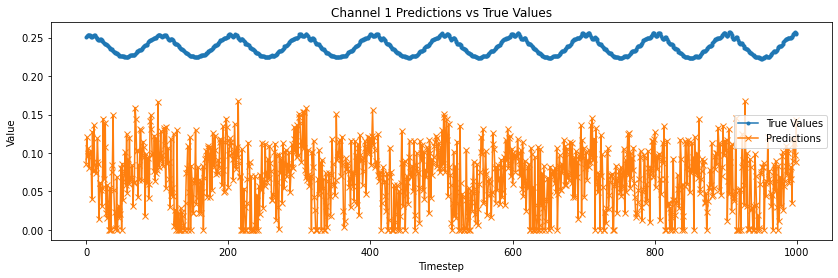

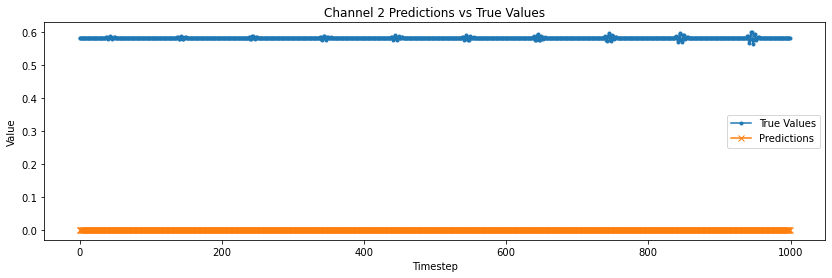

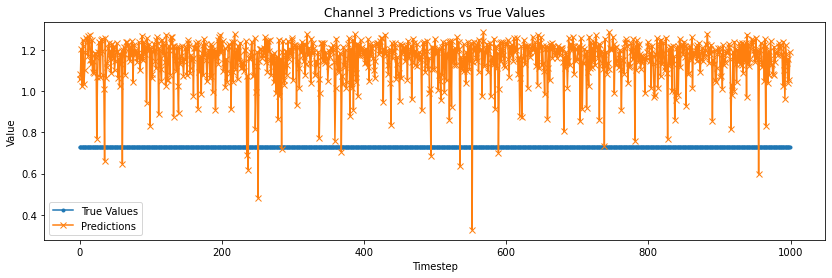

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Make predictions on the test data
test_predictions = model.predict(testing_data_normalized)

# Reshape the predictions and true values for evaluation
y_true = testing_data[:, :, -predicted_snapshots:, :].reshape(-1, num_channels * predicted_snapshots * num_points)
y_pred = test_predictions.reshape(-1, num_channels * predicted_snapshots * num_points)

# Calculate evaluation metrics
mse = mean_squared_error(y_true, y_pred)
mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_true, y_pred)

print(f"Mean Squared Error (MSE) on Test Data: {mse}")
print(f"Mean Absolute Error (MAE) on Test Data: {mae}")
print(f"R-squared (R²) on Test Data: {r2}")

# Visualize the predictions against the true values
# We will visualize one sample for each channel
for i in range(num_channels):
    plt.figure(figsize=(14, 4))
    
    # Select a random test sample index
    sample_index = np.random.randint(low=0, high=testing_data_normalized.shape[0])
    
    # Plot the true values
    plt.plot(y_true[sample_index, i * predicted_snapshots * num_points:(i + 1) * predicted_snapshots * num_points], label='True Values', marker='.')
    
    # Plot the predicted values
    plt.plot(y_pred[sample_index, i * predicted_snapshots * num_points:(i + 1) * predicted_snapshots * num_points], label='Predictions', marker='x')
    
    # Titles and labels
    plt.title(f'Channel {i + 1} Predictions vs True Values')
    plt.xlabel('Timestep')
    plt.ylabel('Value')
    plt.legend()
    plt.show()


Model: "model_32"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_56 (InputLayer)          [(None, 3, 50, 100)  0           []                               
                                ]                                                                 
                                                                                                  
 lambda_105 (Lambda)            (None, 50, 100)      0           ['input_56[0][0]']               
                                                                                                  
 lambda_106 (Lambda)            (None, 50, 100)      0           ['input_56[0][0]']               
                                                                                                  
 lambda_107 (Lambda)            (None, 50, 100)      0           ['input_56[0][0]']        

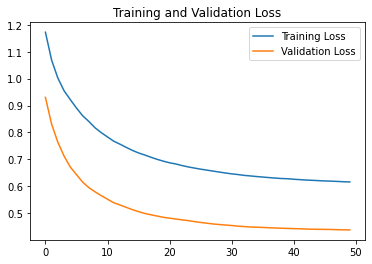

In [100]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
import matplotlib.pyplot as plt

# Load the simulation data
data = np.load('simulation_data.npz')
training_data = data['training_data']
testing_data = data['testing_data']

# Define dimensions
num_samples = training_data.shape[0]
num_channels = training_data.shape[1]
num_snapshots = training_data.shape[2]
num_points = training_data.shape[3]
predicted_snapshots = 10  # How many future snapshots to predict

# Normalize the data
mean = training_data.mean(axis=(0, 2), keepdims=True)
std = training_data.std(axis=(0, 2), keepdims=True)
training_data_normalized = (training_data - mean) / std
testing_data_normalized = (testing_data - mean) / std

# Seq2Seq Model Creation
def create_seq2seq_model():
    # Encoder
    encoder_inputs = keras.Input(shape=(num_channels, num_snapshots, num_points))
    processed_channels = []
    for i in range(num_channels):
        channel_input = layers.Lambda(lambda x: x[:, i, :, :])(encoder_inputs)
        channel_input = layers.Reshape((num_snapshots, num_points, 1))(channel_input)
        cnn = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(channel_input)
        cnn = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(cnn)
        cnn = layers.BatchNormalization()(cnn)
        cnn = layers.MaxPooling2D((2, 2))(cnn)
        cnn = layers.Flatten()(cnn)
        cnn = layers.Reshape((num_snapshots, -1))(cnn)
        processed_channels.append(cnn)

    encoder_concat = layers.Concatenate(axis=-1)(processed_channels)
    encoder_outputs, state_h, state_c = layers.LSTM(128, return_state=True)(encoder_concat)
    encoder_states = [state_h, state_c]

    # Decoder
    decoder_inputs = keras.Input(shape=(predicted_snapshots, num_points * num_channels))
    decoder_lstm = layers.LSTM(128, return_sequences=True)
    decoder_outputs = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = layers.TimeDistributed(layers.Dense(num_points * num_channels, activation='relu'))
    decoder_outputs = decoder_dense(decoder_outputs)
    output_layer = layers.Reshape((num_channels, predicted_snapshots, num_points))(decoder_outputs)

    model = keras.Model([encoder_inputs, decoder_inputs], output_layer)
    model.compile(optimizer='adam', loss='mse')
    return model

# Instantiate and compile the model
model = create_seq2seq_model()
model.summary()

# Prepare the decoder input data, it should be the last known snapshot used to start the prediction process
decoder_input_data = training_data_normalized[:, :, -predicted_snapshots:, :].reshape(num_samples, predicted_snapshots, -1)

# EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Function that updates the learning rate
def lr_schedule(epoch, lr):
    if epoch > 10 and epoch % 2 == 0:
        lr = lr * tf.math.exp(-0.1)
    return lr

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=0)

history = model.fit(
    [training_data_normalized, decoder_input_data],  # Real decoder input needs to be defined
    training_data_normalized[:, :, -predicted_snapshots:, :],
    batch_size=32,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping, lr_scheduler]
)

# Evaluate the model on the test data
test_loss = model.evaluate(
    [testing_data_normalized, decoder_input_data],  # Real test decoder input needs to be defined
    testing_data_normalized[:, :, -predicted_snapshots:, :],
    verbose=0
)
print('Test Loss:', test_loss)

# Visualization of training and validation losses
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

4/4 [==============================] - 6s 627ms/step


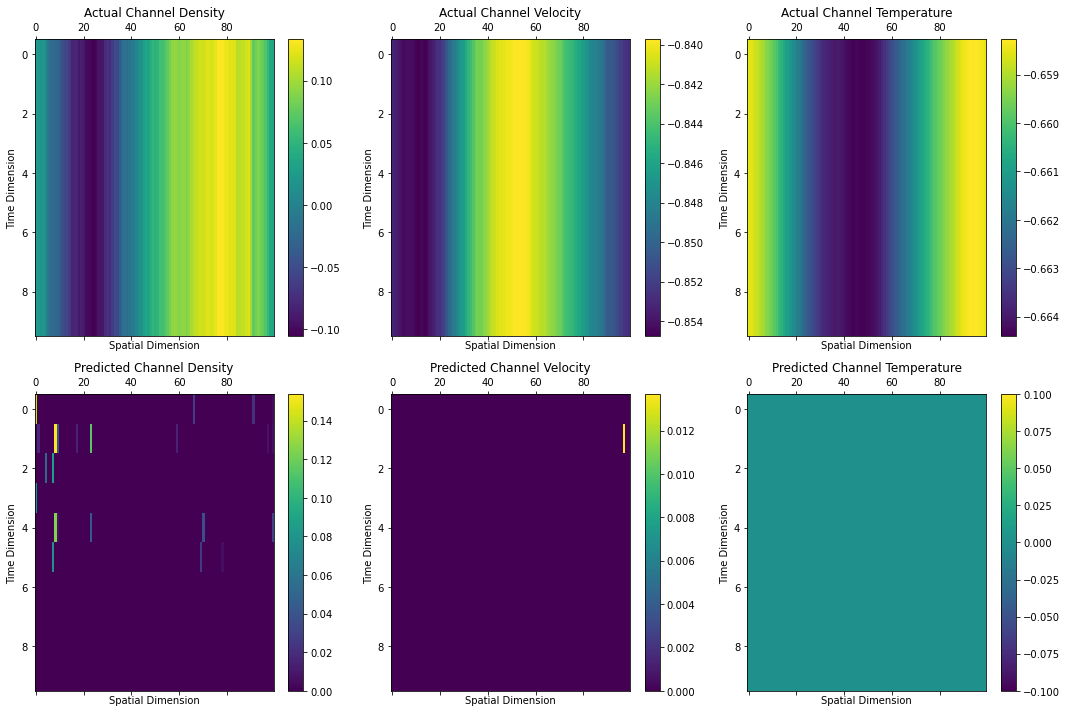

Mean Squared Error (MSE) on Test Data: 1.8362733294694098
Mean Absolute Error (MAE) on Test Data: 0.9749100942037855
R-squared (R²) on Test Data: -0.48777992114708757


In [101]:
# Predictions and Visualization
def plot_actual_vs_predicted(sample_index, actual, predicted, num_channels):
    fig, axes = plt.subplots(nrows=2, ncols=num_channels, figsize=(15,10))  # Adjust the figure size as needed

    field_names = ['Density', 'Velocity', 'Temperature']
    # Plot actual heatmaps
    for i in range(num_channels):
        ax = axes[0, i]
        cax = ax.matshow(actual[sample_index, i, -predicted_snapshots:, :], aspect='auto')
        fig.colorbar(cax, ax=ax)
        ax.set_title(f'Actual Channel {field_names[i]}')
        ax.set_xlabel('Spatial Dimension')
        ax.set_ylabel('Time Dimension')

    # Plot predicted heatmaps
    for i in range(num_channels):
        ax = axes[1, i]
        cax = ax.matshow(predicted[sample_index, i, -predicted_snapshots:, :], aspect='auto')
        fig.colorbar(cax, ax=ax)
        ax.set_title(f'Predicted Channel {field_names[i]}')
        ax.set_xlabel('Spatial Dimension')
        ax.set_ylabel('Time Dimension')

    # Adjust layout
    plt.tight_layout()
    plt.show()
    
actual_data = testing_data_normalized[:, :, -predicted_snapshots:, :]
predicted_outputs = model.predict([testing_data_normalized, decoder_input_data])

# Sample index to visualize
sample_index = np.random.randint(0, num_samples)

plot_actual_vs_predicted(sample_index, actual_data, predicted_outputs, num_channels)

#####################################################################################
#####################################################################################
#####################################################################################

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Reshape the predictions and true values for evaluation
actual_data_metrics_test = actual_data.reshape(-1, num_channels * predicted_snapshots * num_points)
predicted_outputs_metrics_test = predicted_outputs.reshape(-1, num_channels * predicted_snapshots * num_points)

# Calculate evaluation metrics
mse = mean_squared_error(actual_data_metrics_test, predicted_outputs_metrics_test)
mae = mean_absolute_error(actual_data_metrics_test, predicted_outputs_metrics_test)
r2 = r2_score(actual_data_metrics_test, predicted_outputs_metrics_test)

print(f"Mean Squared Error (MSE) on Test Data: {mse}")
print(f"Mean Absolute Error (MAE) on Test Data: {mae}")
print(f"R-squared (R²) on Test Data: {r2}")


In [11]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Load the simulation data
data = np.load('simulation_data.npz')
training_data = data['training_data']
testing_data = data['testing_data']

# Define dimensions based on your data
num_samples = training_data.shape[0]
num_channels = training_data.shape[1]
num_snapshots = training_data.shape[2]
num_points = training_data.shape[3]

# Normalize the data
mean = np.mean(training_data, axis=(0, 2, 3), keepdims=True)
std = np.std(training_data, axis=(0, 2, 3), keepdims=True)

training_data_normalized = (training_data - mean) / std
testing_data_normalized = (testing_data - mean) / std

# Model architecture
model = keras.Sequential([
    # Input layer
    layers.Input(shape=(num_channels, num_snapshots, num_points)),
    # Reshape to data to optimal shape for 1D CNN
    layers.Reshape((num_snapshots, num_points, num_channels)),
    # 1D CNN for Spatial Feature Extraction
    layers.TimeDistributed(layers.Conv1D(32, kernel_size=3, activation='relu', padding='same')),
    # Reshape to combine channels after 1D Conv
    layers.Reshape((num_snapshots, num_points * 32)),
    # Reshape for applying 2D convolutions, treating each time snapshot as an individual "image"
    layers.Reshape((num_snapshots, num_points, 32, 1)),
    # 2D CNN for Combined Spatial Features
    layers.TimeDistributed(layers.Conv2D(64, kernel_size=(3,3), activation='relu', padding='same')),
    # Flatten to feed into LSTM
    layers.Reshape((num_snapshots, -1)),
    # LSTM for Temporal Analysis
    layers.LSTM(64),
    # Dense Layer for Output
    layers.Dense(num_channels * num_snapshots * num_points),
    # Reshape to output shape
    layers.Reshape((num_channels, num_snapshots, num_points))
])

# Print model summary for debugging
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 reshape_5 (Reshape)         (None, 50, 100, 3)        0         
                                                                 
 time_distributed_2 (TimeDis  (None, 50, 100, 32)      320       
 tributed)                                                       
                                                                 
 reshape_6 (Reshape)         (None, 50, 3200)          0         
                                                                 
 reshape_7 (Reshape)         (None, 50, 100, 32, 1)    0         
                                                                 
 time_distributed_3 (TimeDis  (None, 50, 100, 32, 64)  640       
 tributed)                                                       
                                                                 
 reshape_8 (Reshape)         (None, 50, 204800)       

In [16]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Define the ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,  # Reduction factor; new_lr = lr * factor
    patience=5,  # Number of epochs with no improvement after which learning rate will be reduced
    min_lr=1e-6,  # Lower bound on the learning rate
    verbose=1  # If set to 1, the method will print messages when reducing the learning rate
)

# Early Stopping
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True)

# Compile the model
model.compile(
    optimizer='adam',
    loss='mean_squared_error'
)

# Fit the model with the learning rate scheduler
history = model.fit(
    training_data_normalized, 
    training_data_normalized,  # Replace with actual targets if different from the input
    epochs=100,
    batch_size=32, 
    validation_split=0.2,
    callbacks=[reduce_lr, early_stopping]  # Add early_stopping if you wish to use it
)

# Plot the training history
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

Epoch 1/100
1/3 [=========>....................] - ETA: 1:16 - loss: 0.7324


KeyboardInterrupt



In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predict using the model on the testing data
predictions = model.predict(testing_data_normalized)

# Reshape predictions and testing data if needed, then calculate evaluation metrics
# Flatten the arrays to compare every element
predictions_flat = predictions.reshape(-1)
testing_data_flat = testing_data_normalized.reshape(-1)

mse = mean_squared_error(testing_data_flat, predictions_flat)
mae = mean_absolute_error(testing_data_flat, predictions_flat)
r2 = r2_score(testing_data_flat, predictions_flat)

# Print out the evaluation metrics
print(f'Mean Squared Error (MSE): {mse}')
print(f'Mean Absolute Error (MAE): {mae}')
print(f'R^2 Score: {r2}')

4/4 [==============================] - 13s 3s/step
MSE: 2.878809320863815
MAE: 1.0432190356195943
R^2 Score: 0.04748362675862439


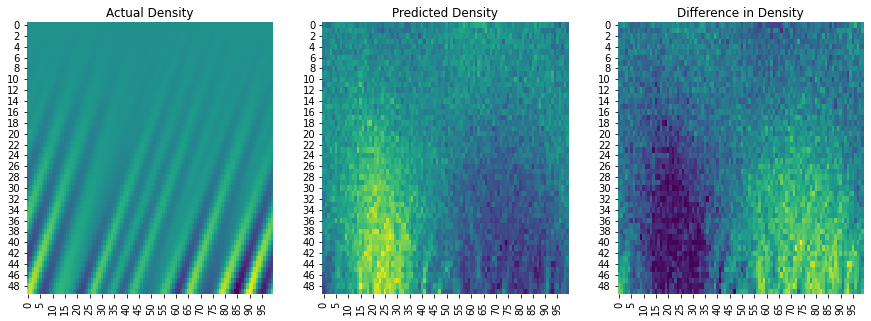

In [15]:
# Visualization function for heatmaps
def plot_heatmaps(actual, predicted, snapshot_num):
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))
    
    # Ensure that the predicted data is reshaped to match the actual data dimensions
    predicted_reshaped = predicted.reshape(actual.shape)
    
    sns.heatmap(actual[0, snapshot_num, :, :], ax=axes[0], cbar=False, cmap='viridis')
    axes[0].set_title('Actual Density')
    sns.heatmap(predicted[0, snapshot_num, :, :], ax=axes[1], cbar=False, cmap='viridis')
    axes[1].set_title('Predicted Density')
    sns.heatmap(abs(actual[0, snapshot_num, :, :] - predicted[0, snapshot_num, :, :]), ax=axes[2], cbar=False, cmap='viridis')
    axes[2].set_title('Difference in Density')
    
    plt.show()

# Example usage of the heatmap visualization function
plot_heatmaps(testing_data, predictions, snapshot_num=0)